Expected Returns (Annualized):
TSLA: 17.3370%, BND: 1.8088%, SPY: 12.8134%

Annualized Covariance Matrix:
          TSLA       BND       SPY
TSLA  0.348284  0.001942  0.053396
BND   0.001942  0.003027  0.001169
SPY   0.053396  0.001169  0.033420


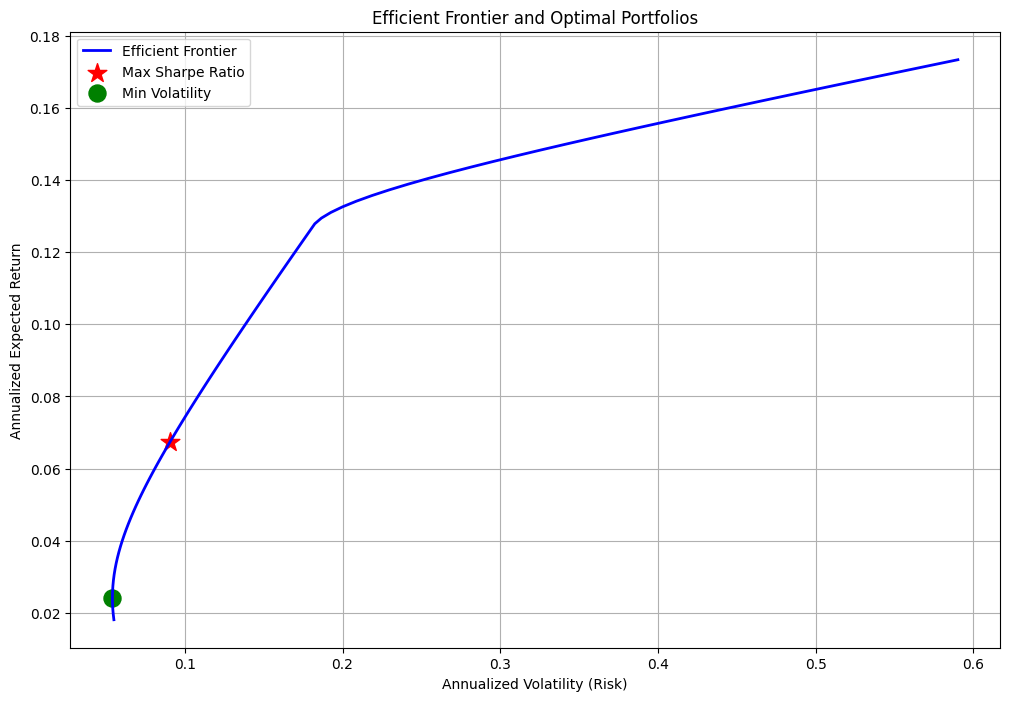


Recommended Portfolio Based on Maximum Sharpe Ratio:
TSLA weight: 0.00%
BND weight: 55.34%
SPY weight: 44.66%
Expected annual return: 6.72%
Annual volatility: 9.04%
Sharpe Ratio: 0.74


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 1. Load historical price data for BND, SPY, TSLA
bnd_df = pd.read_csv('../data/processed/bnd_processed.csv', index_col=0, parse_dates=True)
spy_df = pd.read_csv('../data/processed/spy_processed.csv', index_col=0, parse_dates=True)
tsla_hist_df = pd.read_csv('../data/processed/tsla_processed.csv', index_col=0, parse_dates=True)

# 2. Compute daily log returns for BND and SPY
bnd_returns = np.log(bnd_df['Close'] / bnd_df['Close'].shift(1)).dropna()
spy_returns = np.log(spy_df['Close'] / spy_df['Close'].shift(1)).dropna()

# 3. Load TSLA forecast prices (SARIMA forecast output series)
# Replace this with your actual forecast series variable
# e.g., sarima_forecast from your forecasting step (pandas Series indexed by date)
# Here, assumed to be loaded or computed beforehand
tsla_forecast = pd.read_csv('../data/processed/tsla_sarima_forecast.csv', index_col=0, parse_dates=True)['Forecast']

# Compute TSLA forecast returns as daily log returns
tsla_forecast_returns = np.log(tsla_forecast / tsla_forecast.shift(1)).dropna()

# 4. Calculate expected annual returns
trading_days = 252
bnd_exp_return = bnd_returns.mean() * trading_days
spy_exp_return = spy_returns.mean() * trading_days
tsla_exp_return = tsla_forecast_returns.mean() * trading_days

expected_returns = np.array([tsla_exp_return, bnd_exp_return, spy_exp_return])

print(f"Expected Returns (Annualized):")
print(f"TSLA: {tsla_exp_return:.4%}, BND: {bnd_exp_return:.4%}, SPY: {spy_exp_return:.4%}")

# 5. Compute annualized covariance matrix using historical returns of TSLA, BND, SPY
tsla_hist_returns = np.log(tsla_hist_df['Close'] / tsla_hist_df['Close'].shift(1)).dropna()

# Align data on common dates for covariance calculation
returns_df = pd.concat([tsla_hist_returns, bnd_returns, spy_returns], axis=1, join='inner')
returns_df.columns = ['TSLA', 'BND', 'SPY']

cov_matrix = returns_df.cov() * trading_days

print("\nAnnualized Covariance Matrix:")
print(cov_matrix)

# 6. Define portfolio performance and optimization functions

def portfolio_performance(weights, returns, cov_matrix):
    port_return = np.dot(weights, returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = port_return / port_volatility
    return port_return, port_volatility, sharpe_ratio

def neg_sharpe_ratio(weights, returns, cov_matrix):
    return -portfolio_performance(weights, returns, cov_matrix)[2]

def minimize_volatility(weights, returns, cov_matrix):
    return portfolio_performance(weights, returns, cov_matrix)[1]

# 7. Set constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in expected_returns)
init_guess = np.array([1/3, 1/3, 1/3])

# 8. Optimize for Maximum Sharpe Ratio Portfolio
max_sharpe = minimize(neg_sharpe_ratio, init_guess,
                      args=(expected_returns, cov_matrix),
                      method='SLSQP', bounds=bounds,
                      constraints=constraints)

# 9. Optimize for Minimum Volatility Portfolio
min_volatility = minimize(minimize_volatility, init_guess,
                          args=(expected_returns, cov_matrix),
                          method='SLSQP', bounds=bounds,
                          constraints=constraints)

# 10. Compute Efficient Frontier
target_returns = np.linspace(min(returns_df.mean() * trading_days),
                             max(expected_returns), 100)

efficient_vols = []
for ret in target_returns:
    constraints_ef = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.dot(x, expected_returns) - ret}
    )
    result = minimize(minimize_volatility, init_guess,
                      args=(expected_returns, cov_matrix),
                      method='SLSQP', bounds=bounds,
                      constraints=constraints_ef)
    efficient_vols.append(result.fun if result.success else np.nan)

# 11. Plot Efficient Frontier and Key Portfolios
plt.figure(figsize=(12, 8))
plt.plot(efficient_vols, target_returns, label='Efficient Frontier', color='blue', linewidth=2)

max_sharpe_return, max_sharpe_vol, _ = portfolio_performance(max_sharpe.x, expected_returns, cov_matrix)
plt.scatter(max_sharpe_vol, max_sharpe_return, marker='*', color='red', s=200, label='Max Sharpe Ratio')

min_vol_return, min_vol_vol, _ = portfolio_performance(min_volatility.x, expected_returns, cov_matrix)
plt.scatter(min_vol_vol, min_vol_return, marker='o', color='green', s=150, label='Min Volatility')

plt.title('Efficient Frontier and Optimal Portfolios')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Expected Return')
plt.legend()
plt.grid(True)
plt.show()




# 12. Print Recommended Portfolio based on Maximum Sharpe Ratio
print("\nRecommended Portfolio Based on Maximum Sharpe Ratio:")
print(f"TSLA weight: {max_sharpe.x[0]:.2%}")
print(f"BND weight: {max_sharpe.x[1]:.2%}")
print(f"SPY weight: {max_sharpe.x[2]:.2%}")
print(f"Expected annual return: {max_sharpe_return:.2%}")
print(f"Annual volatility: {max_sharpe_vol:.2%}")
print(f"Sharpe Ratio: {(max_sharpe_return / max_sharpe_vol):.2f}")
